In [1]:
%load_ext autoreload
%autoreload 2

import torch
import esm
import pandas as pd
import numpy as np
from Shared_Functions import *

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR, LinearSVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import KFold

# Load embeddings and make into csv

In [9]:
ref_spike_seq = 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT'

In [3]:
dms_results=decompress_pickle('DMS/sarscov2_spike_dms.pbz2')

In [4]:
mutations = list(dms_results['S:0'].keys())

In [6]:
columns = ['label','Mean_Embedding','Logits', 'semantic_score', 'grammaticality', 'relative_grammaticality', 'sequence_grammaticality', 'relative_sequence_grammaticality', 'probability']
table = []
for key in mutations:
    if key != 'Reference':
        row = pd.DataFrame([dms_results['S:0'][key].get(c) for c in columns]).T
        row.columns = columns
        table.append(row)
table = pd.concat(table)
table

In [11]:
model, alphabet = esm.pretrained.load_model_and_alphabet('esm2_t36_3B_UR50D')
model.eval()
batch_converter = alphabet.get_batch_converter()
device = torch.device("cuda")
if torch.cuda.is_available():
    model =  model.to(device)
    print("Transferred model to GPU")

In [12]:
all_sequence_logits = []
for mutation in table.label:
    seq = mutate_sequence(ref_spike_seq,[mutation])
    logit = table[table.label == mutation].Logits[0]
    sequence_row_logits = torch.FloatTensor(logit)
    sequence_logits = []
    for pos in range(len(seq)):
        word = seq[pos]
        word_idx = alphabet.get_idx(word)
        prob = sequence_row_logits[pos + 1, word_idx]
        sequence_logits.append(prob.item())
    all_sequence_logits.append([mutation,sequence_logits])
logits_dataframe = pd.DataFrame(all_sequence_logits)
logits_dataframe.columns = ['label','sequence_logits']

In [15]:
full_table = pd.merge(table,logits_dataframe,how='left',left_on='label',right_on='label')
full_table['position'] = full_table.label.str[1:-1].astype(int)

In [25]:
import ast
full_table.Mean_Embedding = [ast.literal_eval(s) for s in full_table.Mean_Embedding]
full_table.sequence_logits = [ast.literal_eval(s) for s in full_table.sequence_logits]

# Compile DMS Data

In [3]:
#RBD DMS
xbb15_full_dms = pd.read_csv('DMS/Experimental_DMS/Bloom_XBB15__Full_Spike_DMS.csv')
xbb15_full_dms['target'] = 'XBB.1.5'
ba2_full_dms = pd.read_csv('DMS/Experimental_DMS/Bloom_BA2_Full_Spike_DMS.csv')
ba2_full_dms['target'] = 'BA.2'

In [4]:
xbb15_full_dms

,site,wildtype,mutant,human sera escape,spike mediated entry,ACE2 binding,sequential_site,region,target
0,2,F,C,0.01114,0.10100,0.02151,2,other,XBB.1.5
1,2,F,L,0.01876,0.09432,-0.26980,2,other,XBB.1.5
2,2,F,S,0.03169,0.05844,-0.05642,2,other,XBB.1.5
3,2,F,F,0.00000,0.00000,0.00000,2,other,XBB.1.5
4,3,V,A,0.02402,-0.04154,-0.04977,3,other,XBB.1.5
...,...,...,...,...,...,...,...,...,...
8345,1211,K,K,0.00000,0.00000,0.00000,1207,S2,XBB.1.5
8346,1212,W,R,NaN,-2.37700,-0.21050,1208,other,XBB.1.5
8347,1212,W,W,0.00000,0.00000,0.00000,1208,other,XBB.1.5
8348,767,L,L,0.00000,0.00000,0.00000,763,S2,XBB.1.5


In [29]:
xbb15_full_dms = xbb15_full_dms[['target','site','mutant','human sera escape','spike mediated entry','ACE2 binding']]
ba2_full_dms = ba2_full_dms[['target','site','mutant','spike mediated entry','ACE2 binding']]

In [30]:
compliled_full_dms = pd.concat([xbb15_full_dms,ba2_full_dms])
compliled_full_dms
compliled_full_dms.columns = ['target','site','mutant','human sera escape','spike mediated entry','ACE2 binding']
compliled_full_dms = compliled_full_dms.groupby(['site','mutant']).mean().reset_index()
compliled_full_dms.columns = ['position','mutant','human sera escape','spike mediated entry','ACE2 binding']
compliled_full_dms

,position,mutant,human sera escape,spike mediated entry,ACE2 binding
0,1,I,NaN,-6.500500,NaN
1,1,M,0.000000,0.000000,0.000000
2,1,T,NaN,-3.124000,NaN
3,2,C,0.011140,0.101000,0.021510
4,2,F,0.000000,0.000000,0.000000
...,...,...,...,...,...
9851,1252,S,0.000000,0.000000,0.000000
9852,1252,T,0.001764,-0.116373,-0.115950
9853,1252,V,NaN,0.127500,-0.133400
9854,1252,W,NaN,0.155300,0.111900


In [23]:
rbd_dms = pd.read_csv('DMS/Experimental_DMS/Bloom_Spike_RBD_DMS.csv')
rbd_dms = rbd_dms[['target','position','mutant','bind','delta_bind','expr','delta_expr']]

rbd_dms_avg = rbd_dms.drop('target',axis=1).groupby(['position','mutant']).mean().reset_index()
rbd_dms_std = rbd_dms.drop('target',axis=1).groupby(['position','mutant']).std().reset_index()
rbd_variant_dms_avg = pd.merge(rbd_dms_avg,rbd_dms_std,how='left',left_on=['position','mutant'],right_on=['position','mutant'])
rbd_variant_dms_avg.columns = rbd_variant_dms_avg.columns.str.replace('_x','').str.replace('_y','_std').values

rbd_variant_dms_avg['target'] = 'Variant_Average'
rbd_variant_dms_avg.columns = ['position','mutant','variant_average_binding','variant_average_delta_binding','variant_average_expression','variant_average_delta_expression','variant_std_binding','variant_std_delta_binding','variant_std_expression','variant_std_delta_expression','target',]
rbd_variant_dms_avg

In [36]:
wuhan_rbd_dms = rbd_dms[rbd_dms.target == 'Wuhan-Hu-1']
wuhan_rbd_dms.columns = ['target','position','mutant','wuhan_1_binding','wuhan_1_delta_binding','wuhan_1_expression','wuhan_1_delta_expression']

In [37]:
compiled_rbd_dms = pd.merge(wuhan_rbd_dms,
                            rbd_variant_dms_avg[['position','mutant','variant_average_binding','variant_average_delta_binding','variant_average_expression','variant_average_delta_expression']],
                            how='left',
                            left_on=['position','mutant'],
                            right_on = ['position','mutant'],
                           )
compiled_rbd_dms = compiled_rbd_dms.drop('target',axis=1)
compiled_rbd_dms

,position,mutant,wuhan_1_binding,wuhan_1_delta_binding,wuhan_1_expression,wuhan_1_delta_expression,variant_average_binding,variant_average_delta_binding,variant_average_expression,variant_average_delta_expression
0,331,A,8.79360,0.06027,10.29895,0.11422,9.055933,0.046745,9.955055,-0.061815
1,331,C,8.61594,-0.15567,9.67665,-0.50923,8.942490,-0.263522,9.495334,-0.547252
2,331,D,8.75409,-0.01751,10.06985,-0.11602,9.146896,-0.059112,9.919592,-0.122994
3,331,E,8.92561,0.15400,10.18436,-0.00151,9.278162,0.061840,10.045118,-0.009578
4,331,F,8.65690,-0.11470,10.01397,-0.17191,9.024052,-0.182596,9.566928,-0.468396
...,...,...,...,...,...,...,...,...,...,...
4015,531,S,NaN,NaN,NaN,NaN,9.174453,0.073313,9.992480,0.031563
4016,531,T,8.77161,0.00000,10.18588,0.00000,9.206012,0.000000,10.042586,0.000000
4017,531,V,8.71791,-0.01541,10.31504,0.13031,9.422002,0.145155,9.999930,-0.021157
4018,531,W,8.72554,-0.00779,10.19057,0.00584,9.138790,-0.058294,9.865196,-0.184424


In [38]:
all_dms = pd.merge(compliled_full_dms,compiled_rbd_dms.drop(['wuhan_1_delta_binding','wuhan_1_delta_expression','variant_average_delta_binding','variant_average_delta_expression'],axis=1),how='left',
                            left_on=['position','mutant'],
                            right_on = ['position','mutant'],)
all_dms

,position,mutant,human sera escape,spike mediated entry,ACE2 binding,wuhan_1_binding,wuhan_1_expression,variant_average_binding,variant_average_expression
0,1,I,NaN,-6.500500,NaN,NaN,NaN,NaN,NaN
1,1,M,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
2,1,T,NaN,-3.124000,NaN,NaN,NaN,NaN,NaN
3,2,C,0.011140,0.101000,0.021510,NaN,NaN,NaN,NaN
4,2,F,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
9851,1252,S,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
9852,1252,T,0.001764,-0.116373,-0.115950,NaN,NaN,NaN,NaN
9853,1252,V,NaN,0.127500,-0.133400,NaN,NaN,NaN,NaN
9854,1252,W,NaN,0.155300,0.111900,NaN,NaN,NaN,NaN


# Accessibility

In [39]:
accessibility = pd.read_csv('DMS/Structural_Data/Woo_ab_accessibility.csv')
accessibility = accessibility[['position','epitope_max']]
accessibility

,position,epitope_max
0,1,0.678571
1,2,0.748848
2,3,0.711982
3,4,0.698157
4,5,0.601382
...,...,...
1269,1270,NaN
1270,1271,NaN
1271,1272,NaN
1272,1273,NaN


# Structural Data

In [40]:
structure_data = pd.read_csv('DMS/Structural_Data/6vxx_master_scores.csv')
structure_data['position'] = structure_data.Replacement.str[1:-1]
structure_data['mutant'] = structure_data.Replacement.str[-1]
structure_data = structure_data.drop(['Resno','Chain','WTAA','ReplacementAA','Replacement'],axis=1)
structure_data = structure_data.drop_duplicates()
structure_data = structure_data.drop(['deltaRosetta_hard','deltaRosetta_soft','LogLikelihood'],axis=1)
structure_data

# Entropy

In [44]:
entropy = pd.read_csv('DMS/Entropy/entropy_table.csv')

# Cao Mutational Effects

In [43]:
cao = pd.read_csv('DMS/Experimental_DMS/Cao_Escape.csv')
cao['position'] = cao.label.str[1:-1].astype(int)
cao['mutant'] = cao.label.str[-1].astype(str)

In [44]:

# cao = cao.drop()

# Combined Metadata

In [45]:
full_table = full_table[['label', 'Mean_Embedding', 'Logits', 'semantic_score', 'grammaticality',
       'relative_grammaticality', 'sequence_grammaticality',
       'relative_sequence_grammaticality', 'probability', 'sequence_logits']]
full_table['position'] = full_table.label.str[1:-1].astype(int)
full_table['mutant'] = full_table.label.str[-1].astype(str)
full_table

In [48]:
structure_data.position = structure_data.position.astype(int)

In [49]:
full_table_metadata = pd.merge(full_table,all_dms,how='left',left_on=['position','mutant'],right_on=['position','mutant'])

In [50]:
full_table_metadata = pd.merge(full_table_metadata,structure_data,how='left',left_on=['position','mutant'],right_on=['position','mutant'])
full_table_metadata = pd.merge(full_table_metadata,entropy,how='left',left_on='position',right_on='position')
full_table_metadata = pd.merge(full_table_metadata,accessibility,how='left',left_on='position',right_on='position')
full_table_metadata = pd.merge(full_table_metadata,cao,how='left',left_on=['position','mutant'],right_on=['position','mutant'])

In [51]:
full_table_metadata.rename({'Likelihood':'PSST',
                            'entropy':'Entropy',
                            'ESST_probability':'ESST',
                            'epitope_max':'Accessibility',
                            'human sera escape':'Escape',
                            'spike mediated entry':'Entry',
                            'ACE2 binding':'Binding',
                            'wuhan_1_binding':'RBD Wuhan-Hu-1 Binding',
                            'wuhan_1_expression':'RBD Wuhan-Hu-1 Expression',
                            'variant_average_binding':'RBD Variant Average Binding',
                            'variant_average_expression':'RBD Variant Average Expression',
                            'Cao_mut_escape':'RBD Escape'
                           },inplace=True,axis=1)

# Combine Data and Metadata

In [19]:
features = ['semantic_score','relative grammaticality','relative_sequence_grammaticality','semantic_score/relative grammaticality','semantic_score/relative_sequence_grammaticality','Mean_Embedding','sequence_logits']
predictors = [
    'Escape','RBD Escape',
    'Entry',
    'Binding','RBD Wuhan-Hu-1 Binding','RBD Variant Average Binding',
    'RBD Wuhan-Hu-1 Expression','RBD Variant Average Expression',
    'Accessibility','BFactor','DeltaDeltaG',
    'PSST','ESST','Entropy',
]

In [ ]:
linear_best_predictor_results = []
new = True
for predictor in predictors:
    print('--------------------------------'+predictor.upper()+'--------------------------------')
    if predictor !='entropy':
        data = full_table_metadata[full_table_metadata[predictor].isna() == False]
    else:
        data = full_table_metadata[full_table_metadata[predictor] >0]
    for feature in features:
        print('--------------------------------'+feature.upper()+'--------------------------------')
        if feature == 'semantic_score/relative_sequence_grammaticality':
            X = np.array([[data.semantic_score.values[i],data.relative_sequence_grammaticality.values[i]] for i in range(len(data.semantic_score.values))])
        elif feature == 'semantic_score/relative grammaticality':
            X = np.array([[data.semantic_score.values[i],data.relative_grammaticality.values[i]] for i in range(len(data.semantic_score.values))])
        elif feature == 'semantic_score':
            X = np.array([[data.semantic_score.values[i]] for i in range(len(data.semantic_score.values))])
        elif feature == 'relative grammaticality':
            X = np.array([[data.relative_grammaticality.values[i]] for i in range(len(data.semantic_score.values))])
        elif feature == 'relative_sequence_grammaticality':
            X = np.array([[data.relative_sequence_grammaticality.values[i]] for i in range(len(data.semantic_score.values))])
        else:
            X =np.array(data[feature].to_list())
        y = data[predictor]
        
        train_size = 0.8
        X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        kf = KFold(n_splits=5,shuffle=True)
        for train_index , test_index in kf.split(X):
            X_train , X_test = X.iloc[train_index],X.iloc[test_index]
            y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
            lin_preds = LinearRegression().fit(X_train, y_train).predict(X_test)
            lin_spearman = scipy.stats.spearmanr(y_test, lin_preds)
            linear_best_predictor_results.append(['Linear',lin_spearman.correlation,lin_spearman.pvalue])
#             print(f'Linear:{lin_spearman}')
            
            scaler = StandardScaler()
            scaler = scaler.fit(X_train)
            scaled_Xtrain = scaler.transform(X_train)
            scaled_Xtest = scaler.transform(X_test)
            
            svr = SVR(kernel='rbf')
            svr.fit(scaled_Xtrain,np.ravel(y_train))
            svr_preds =svr.predict(scaled_Xtest)
            svr_spearman = scipy.stats.spearmanr(y_test, svr_preds)
            linear_best_predictor_results.append(['SVR-RBF',svr_spearman.correlation,svr_spearman.pvalue])
            
#             print(f'SVR:{svr_spearman}')
            #Write results to file
            if new != True:
                pd.DataFrame(['Linear',lin_spearman.correlation,lin_spearman.pvalue,predictor,feature],index = ['model','correlation','pvalue','predictor','feature']).T.to_csv(
                    'DMS/Results/Regression/Model_Fitted_Correlations.csv', mode='a', index=False, header=False)
                pd.DataFrame(['SVR-RBF',svr_spearman.correlation,svr_spearman.pvalue,predictor,feature],index = ['model','correlation','pvalue','predictor','feature']).T.to_csv(
                    'DMS/Results/Regression/Model_Fitted_Correlations.csv', mode='a', index=False, header=False)
            else:
                pd.DataFrame(['Linear',lin_spearman.correlation,lin_spearman.pvalue,predictor,feature],index =['model','correlation','pvalue','predictor','feature']).T.to_csv(
                    'DMS/Results/Regression/Model_Fitted_Correlations.csv', index=False,)
                pd.DataFrame(['SVR-RBF',svr_spearman.correlation,svr_spearman.pvalue,predictor,feature],index = ['model','correlation','pvalue','predictor','feature']).T.to_csv(
                    'DMS/Results/Regression/Model_Fitted_Correlations.csv', mode='a', index=False, header=False)
                new=False

--------------------------------ESCAPE--------------------------------
--------------------------------SEMANTIC_SCORE--------------------------------
--------------------------------RELATIVE GRAMMATICALITY--------------------------------
--------------------------------RELATIVE_SEQUENCE_GRAMMATICALITY--------------------------------
--------------------------------SEMANTIC_SCORE/RELATIVE GRAMMATICALITY--------------------------------
--------------------------------SEMANTIC_SCORE/RELATIVE_SEQUENCE_GRAMMATICALITY--------------------------------
--------------------------------MEAN_EMBEDDING--------------------------------
--------------------------------SEQUENCE_LOGITS--------------------------------
--------------------------------CAO ESCAPE--------------------------------
--------------------------------SEMANTIC_SCORE--------------------------------
--------------------------------RELATIVE GRAMMATICALITY--------------------------------
--------------------------------RELATIVE_SEQUENCE

In [5]:
import pandas as pd
linear_best_predictor_results_df = pd.read_csv('DMS/Results/Regression/Model_Fitted_Correlations.csv')

In [6]:
# linear_best_predictor_results_df.to_csv('CSV/Correlations/Model_Fitted_Correlations.csv',index=False)

In [7]:
linear_best_predictor_results_df[linear_best_predictor_results_df.model == 'Linear']

,model,correlation,pvalue,predictor,feature
0,Linear,0.070005,9.946638e-03,Escape,semantic_score
2,Linear,0.096436,3.782178e-04,Escape,semantic_score
4,Linear,0.112366,3.389828e-05,Escape,semantic_score
6,Linear,0.098699,2.740451e-04,Escape,semantic_score
8,Linear,0.120500,8.743423e-06,Escape,semantic_score
...,...,...,...,...,...
970,Linear,0.279519,2.138044e-92,Entropy,sequence_logits
972,Linear,0.259954,9.867241e-80,Entropy,sequence_logits
974,Linear,0.243653,5.602081e-70,Entropy,sequence_logits
976,Linear,0.244706,1.379132e-70,Entropy,sequence_logits


In [9]:
linear_subset = linear_best_predictor_results_df[linear_best_predictor_results_df.model == 'Linear'].drop('model',axis=1)

linear_avg_correlation = linear_subset[['feature','predictor','correlation']].groupby(['feature','predictor']).mean()
linear_avg_correlation.columns = ['mean_correlation']
linear_avg_correlation = linear_avg_correlation.reset_index()

linear_max_pvalue = linear_subset[['feature','predictor','pvalue']].groupby(['feature','predictor']).max()
linear_max_pvalue.columns = ['max_pvalue']
linear_max_pvalue = linear_max_pvalue.reset_index()

linear_expanded_best_pred_df = pd.merge(linear_subset,linear_avg_correlation,how='left',left_on=['feature','predictor'],right_on=['feature','predictor'])
linear_expanded_best_pred_df = pd.merge(linear_expanded_best_pred_df,linear_max_pvalue,how='left',left_on=['feature','predictor'],right_on=['feature','predictor'])
linear_expanded_best_pred_df['bonferroni_corrected_max_pvalue'] = linear_expanded_best_pred_df.max_pvalue*len(linear_expanded_best_pred_df.predictor.unique())
linear_expanded_best_pred_df['bonferroni_max_significant'] = [ True if p <=0.05 else False for p in linear_expanded_best_pred_df.bonferroni_corrected_max_pvalue]

linear_filtered_bar_data = linear_expanded_best_pred_df[linear_expanded_best_pred_df.bonferroni_max_significant==True][['feature','predictor','correlation','mean_correlation','bonferroni_corrected_max_pvalue']].drop_duplicates()
linear_filtered_bar_data

linear_bar_data = linear_filtered_bar_data[['predictor','feature','mean_correlation']].drop_duplicates().pivot(index="predictor", columns="feature", values="mean_correlation")

In [10]:
linear_expanded_best_pred_df.to_csv('DMS/Results/Regression/linear_correlations_with_dms.csv')
linear_expanded_best_pred_df[linear_expanded_best_pred_df.bonferroni_max_significant == True].to_csv('DMS/Results/Regression/linear_svr_significant_correlations_with_dms.csv')

<AxesSubplot:xlabel='predictor'>

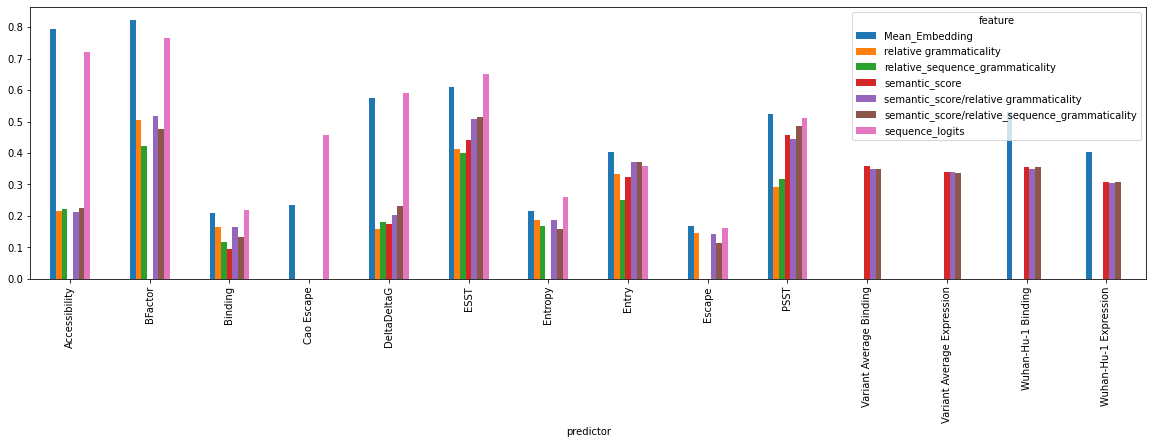

In [11]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=[20,5])
linear_bar_data.plot(kind='bar',ax=ax)

In [12]:
svr_subset = linear_best_predictor_results_df[linear_best_predictor_results_df.model == 'SVR-RBF'].drop('model',axis=1)

svr_avg_correlation = svr_subset[['feature','predictor','correlation']].groupby(['feature','predictor']).mean()
svr_avg_correlation.columns = ['mean_correlation']
svr_avg_correlation = svr_avg_correlation.reset_index()

svr_max_pvalue = svr_subset[['feature','predictor','pvalue']].groupby(['feature','predictor']).max()
svr_max_pvalue.columns = ['max_pvalue']
svr_max_pvalue = svr_max_pvalue.reset_index()

svr_expanded_best_pred_df = pd.merge(svr_subset,svr_avg_correlation,how='left',left_on=['feature','predictor'],right_on=['feature','predictor'])
svr_expanded_best_pred_df = pd.merge(svr_expanded_best_pred_df,svr_max_pvalue,how='left',left_on=['feature','predictor'],right_on=['feature','predictor'])
svr_expanded_best_pred_df['bonferroni_corrected_max_pvalue'] = svr_expanded_best_pred_df.max_pvalue*len(svr_expanded_best_pred_df.predictor.unique())
svr_expanded_best_pred_df['bonferroni_max_significant'] = [ True if p <=0.05 else False for p in svr_expanded_best_pred_df.bonferroni_corrected_max_pvalue]

svr_filtered_bar_data = svr_expanded_best_pred_df[svr_expanded_best_pred_df.bonferroni_max_significant==True][['feature','predictor','correlation','mean_correlation','bonferroni_corrected_max_pvalue']].drop_duplicates()

svr_bar_data = svr_filtered_bar_data[['predictor','feature','mean_correlation']].drop_duplicates().pivot(index="predictor", columns="feature", values="mean_correlation")

In [13]:
svr_expanded_best_pred_df.to_csv('Results/Regression/svr_correlations_with_dms.csv')
svr_expanded_best_pred_df[svr_expanded_best_pred_df.bonferroni_max_significant == True].to_csv('DMS/Results/Regression/svr_significant_correlations_with_dms.csv')

<AxesSubplot:xlabel='predictor'>

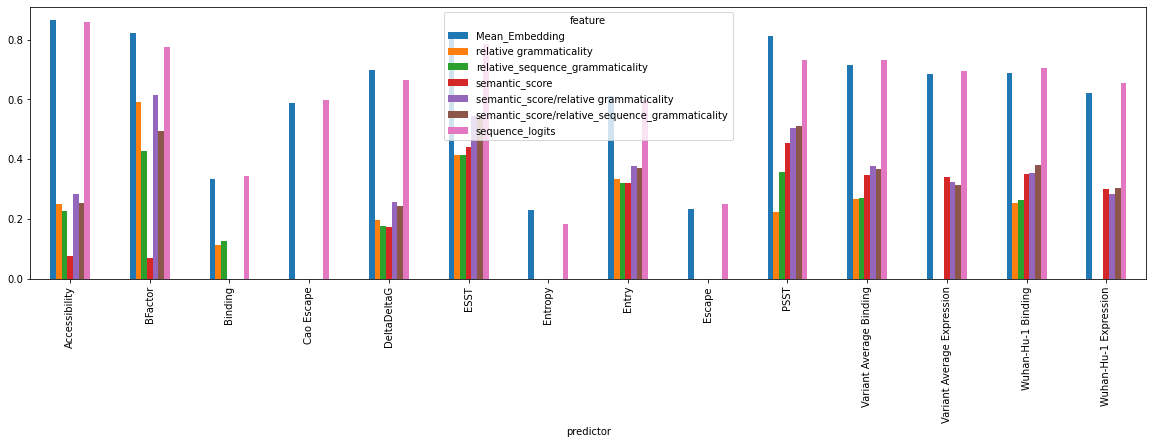

In [14]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=[20,5])
svr_bar_data.plot(kind='bar',ax=ax)

In [15]:
filtered_bar_data[['feature','predictor','mean_correlation','bonferroni_corrected_max_pvalue']].drop_duplicates().to_csv('DMS/Results/Regression/bonferroni_corrected_svr_correlations_with_dms_data_unpivoted.csv')

NameError: name 'filtered_bar_data' is not defined

In [391]:
filtered_bar_data[['feature','predictor','correlation','mean_correlation','bonferroni_corrected_max_pvalue']].to_csv('DMS/Results/Regression/bonferroni_corrected_svr_correlations_with_dms_data_all_unpivoted.csv')


In [342]:
filtered_bar_data.drop(['parameters'],axis=1).drop_duplicates().to_csv('DMS/Results/Regression/bonferroni_corrected_svr_correlations_with_dms_data_unpivoted.csv')

In [328]:
bar_data.to_csv('DMS/Results/Regression/bonferroni_corrected_svr_correlations_with_dms_data.csv')

# Single Value Correlations

In [20]:
predictor_col = []
feature_col = []
for predictor in predictors:
#     print('--------------------------------'+predictor.upper()+'--------------------------------')
    for feature in features:
#         print('--------------------------------'+feature.upper()+'--------------------------------')
            for i in range(5):  
#                 print(predictor,feature)
                predictor_col.append(predictor)
                feature_col.append(feature)

In [58]:
single_value_features = ['semantic_score','relative_grammaticality','relative_sequence_grammaticality']

In [59]:
single_value_correlations = []
for predictor in predictors:
    if predictor !='entropy':
        data = full_table_metadata[full_table_metadata[predictor].isna() == False]
    else:
        data = full_table_metadata[full_table_metadata[predictor] >0]
    for feature in single_value_features:
        single_value_correlations.append([feature,predictor,scipy.stats.spearmanr(data[feature], data[predictor]).correlation,scipy.stats.spearmanr(data[feature], data[predictor]).pvalue])
        

In [60]:
single_value_correlations_df = pd.DataFrame(single_value_correlations)
single_value_correlations_df.columns = ['feature','predictor','correlation','pvalue']
single_value_correlations_df['bonferroni_corrected_pvalue'] = single_value_correlations_df.pvalue*len(single_value_correlations_df.predictor.unique())
single_value_correlations_df['bonferroni_significant'] = [ True if p <=0.05 else False for p in single_value_correlations_df.bonferroni_corrected_pvalue]

In [61]:
single_value_correlations_df

,feature,predictor,correlation,pvalue,bonferroni_corrected_pvalue,bonferroni_significant
0,semantic_score,Escape,-0.100784,9.204110e-17,1.288575e-15,True
1,relative_grammaticality,Escape,0.144750,4.834097e-33,6.767736e-32,True
2,relative_sequence_grammaticality,Escape,0.078707,8.766396e-11,1.227295e-09,True
3,semantic_score,Cao Escape,0.063417,1.333393e-04,1.866750e-03,True
4,relative_grammaticality,Cao Escape,-0.011999,4.702431e-01,6.583403e+00,False
5,relative_sequence_grammaticality,Cao Escape,-0.021821,1.890770e-01,2.647078e+00,False
6,semantic_score,Entry,-0.324576,1.799812e-233,2.519736e-232,True
7,relative_grammaticality,Entry,0.333861,1.012199e-247,1.417079e-246,True
8,relative_sequence_grammaticality,Entry,0.249928,3.865601e-136,5.411841e-135,True
9,semantic_score,Binding,0.096250,2.208321e-19,3.091650e-18,True


In [62]:
filtered_single_value_correlations_df = single_value_correlations_df[single_value_correlations_df.bonferroni_significant==True]

In [63]:
single_value_correlations_df.to_csv('DMS/Results/Regression/single_value_correlations.csv')
filtered_single_value_correlations_df.to_csv('DMS/Results/Regression/significant_single_value_correlations.csv')

In [64]:
single_bar_data = filtered_single_value_correlations_df.drop_duplicates().pivot(index="predictor", columns="feature", values="correlation")

<AxesSubplot:xlabel='predictor'>

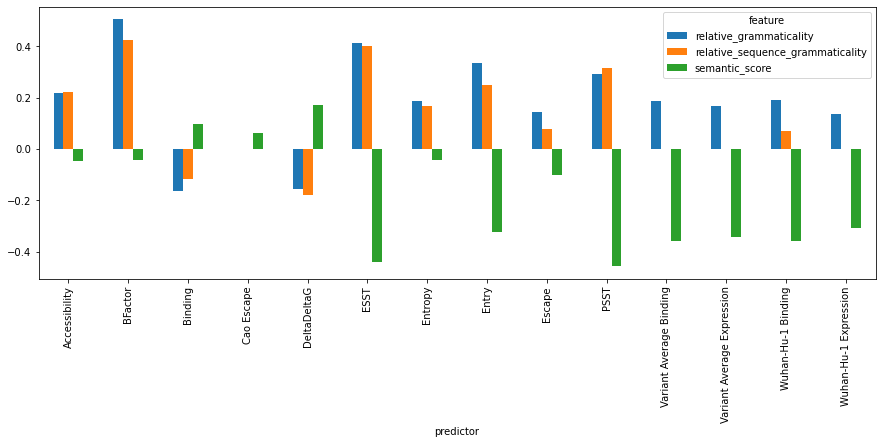

In [65]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=[15,5])
single_bar_data.plot(kind='bar',ax=ax)

In [396]:
filtered_single_value_correlations_df.drop_duplicates().to_csv('DMS/Results/CSV/Regression/bonferroni_single_value_correlations_with_dms_data_unpivoted.csv')

In [2]:
single_bar_data.to_csv('DMS/Results/Regression/bonferroni_single_value_correlations_with_dms_data.csv')